## **RADI605: Modern Machine Learning**

### Assignment: Random Survival Forests
**Romen Samuel Rodis Wabina** <br>
Student, PhD Data Science in Healthcare and Clinical Informatics <br>
Clinical Epidemiology and Biostatistics, Faculty of Medicine (Ramathibodi Hospital) <br>
Mahidol University

Note: In case of Python Markdown errors, you may access the assignment through this GitHub [Link](https://github.com/rrwabina/RADI605/blob/main/05%20Adaptive%20Boosting/scripts/assignment.ipynb)

In [14]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import export as export 
import eli5
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.datasets import load_whas500
from sksurv.tree import SurvivalTree
from sksurv.util import Surv
from sklearn.pipeline import make_pipeline
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from eli5.sklearn import PermutationImportance

In [2]:
X, y = load_whas500()
X.head(10).style.hide_index()

afb,age,av3,bmi,chf,cvd,diasbp,gender,hr,los,miord,mitype,sho,sysbp
1,83.000000,0,25.540510,0,1,78.000000,0,89.000000,5.000000,1,0,0,152.000000
0,49.000000,0,24.023980,0,1,60.000000,0,84.000000,5.000000,0,1,0,120.000000
0,70.000000,0,22.142900,0,0,88.000000,1,83.000000,5.000000,0,1,0,147.000000
0,70.000000,0,26.631870,1,1,76.000000,0,65.000000,10.000000,0,1,0,123.000000
0,70.000000,0,24.412550,0,1,85.000000,0,63.000000,6.000000,0,1,0,135.000000
0,70.000000,1,23.242360,0,1,54.000000,0,76.000000,1.000000,0,0,0,83.000000
0,57.000000,0,39.490460,0,1,116.000000,0,73.000000,5.000000,0,1,0,191.000000
0,55.000000,0,27.116090,0,1,95.000000,0,91.000000,4.000000,0,1,0,147.000000
0,88.000000,0,27.435540,1,1,100.000000,1,63.000000,4.000000,0,0,0,209.000000
0,54.000000,0,25.544480,0,1,106.000000,0,104.000000,5.000000,0,0,0,166.000000


In [3]:
y[:10]

array([(False, 2.178e+03), (False, 2.172e+03), (False, 2.190e+03),
       ( True, 2.970e+02), (False, 2.131e+03), ( True, 1.000e+00),
       (False, 2.122e+03), ( True, 1.496e+03), ( True, 9.200e+02),
       (False, 2.175e+03)], dtype=[('fstat', '?'), ('lenfol', '<f8')])

In [4]:
df_y = pd.DataFrame(data={'time': [y[i][1] for i in range(len(y))], 'event': [y[i][0] for i in range(len(y))]})
df_y[:10].style.hide_index().highlight_min('event', color='lightgreen')

time,event
2178.000000,False
2172.000000,False
2190.000000,False
297.000000,True
2131.000000,False
1.000000,True
2122.000000,False
1496.000000,True
920.000000,True
2175.000000,False


One of the main challenges of survival analysis is right censoring, i.e., by the end of the study, the event of interest (for example, in medicine 'death of a patient' or in this dataset 'recurrence of cancer') has only occurred for a subset of the observations.

The right censoring in this dataset is given by the column named 'event' and it's a variable which can take value 'True' if the patient had a recurrence of cancer or 'False' if the patient is recurrence free at the indicated time (right-censored samples).

Let's see how many right-censored samples do we have.

In [5]:
print(f'Number of samples: {len(df_y)}')
print(f'Number of right censored samples: {len(df_y.query("event == False"))}')
print(f'Percentage of right censored samples: {100*len(df_y.query("event == False"))/len(df_y):.1f}%')

Number of samples: 500
Number of right censored samples: 285
Percentage of right censored samples: 57.0%


There are 387 patients (56.4%) who were right censored (recurrence free) at the end of the study.

Let's divide our dataset in training and test sets.

In [6]:
from sklearn.model_selection import train_test_split

X_trn, X_test, y_trn, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

print(f'Number of training samples: {len(y_trn)}')
print(f'Number of test samples: {len(y_test)}')

Number of training samples: 350
Number of test samples: 150


We divide the features/covariates into continuous and categorical.

In [18]:
scaling_cols = [c for c in X.columns if X[c].dtype.kind in ['i', 'f']]
cat_cols     = [c for c in X.columns if X[c].dtype.kind not in ["i", "f"]]

We use ordinal encoding for categorical features/covariates and standard scaling for continuous features/covariates.

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

preprocessor = ColumnTransformer(
    [('cat-preprocessor', OrdinalEncoder(), cat_cols),
    ('standard-scaler', StandardScaler(), scaling_cols)],
    remainder='passthrough', sparse_threshold=0)

In [20]:
rsf = make_pipeline(preprocessor, RandomSurvivalForest(random_state=42))
rsf.fit(X_trn, y_trn)
ci_rsf = concordance_index_censored(y_test["fstat"], y_test["lenfol"], rsf.predict(X_test))
print(f'The c-index of Random Survival Forest is given by {ci_rsf[0]:.3f}')

The c-index of Random Survival Forest is given by 0.747


In [21]:
class reciprocal_int:
    def __init__(self, a, b):
        self._distribution = reciprocal(a, b)

    def rvs(self, *args, **kwargs):
        return self._distribution.rvs(*args, **kwargs).astype(int)

param_distributions1 = {
    'randomsurvivalforest__max_features': reciprocal_int(3, 8),
    'randomsurvivalforest__max_depth': reciprocal_int(5, 50),
    'randomsurvivalforest__min_samples_leaf': reciprocal_int(1, 40),
}

model_random_search = RandomizedSearchCV(
    rsf, param_distributions=param_distributions1, n_iter=50, n_jobs=-1, cv=3, random_state=0)
model_random_search.fit(X_trn, y_trn)

print(
    f"The c-index of random survival forest using a {model_random_search.__class__.__name__} is "
    f"{model_random_search.score(X_test, y_test):.3f}")
print(
    f"The best set of parameters is: {model_random_search.best_params_}"
)

The c-index of random survival forest using a RandomizedSearchCV is 0.756
The best set of parameters is: {'randomsurvivalforest__max_depth': 6, 'randomsurvivalforest__max_features': 5, 'randomsurvivalforest__min_samples_leaf': 1}


In [15]:
max_depth = model_random_search.best_params_['randomsurvivalforest__max_depth']
max_features = model_random_search.best_params_['randomsurvivalforest__max_features']
min_samples_leaf = model_random_search.best_params_['randomsurvivalforest__min_samples_leaf']

In [22]:
rsf_best = make_pipeline(preprocessor, RandomSurvivalForest(random_state=42, max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf))
rsf_best.fit(X_trn, y_trn)
ci_rsf = concordance_index_censored(y_test["fstat"], y_test["lenfol"], rsf_best.predict(X_test))
print(f'The c-index of Random Survival Forest is given by {ci_rsf[0]:.3f}')

The c-index of Random Survival Forest is given by 0.756


In [23]:
perm = PermutationImportance(rsf.steps[-1][1], n_iter=100).fit(preprocessor.fit_transform(X_trn),y_trn)

data = perm.results_
data = pd.DataFrame(data, columns=X_trn.columns)
meds = data.median()
meds = meds.sort_values(ascending=False)
data = data[meds.index]

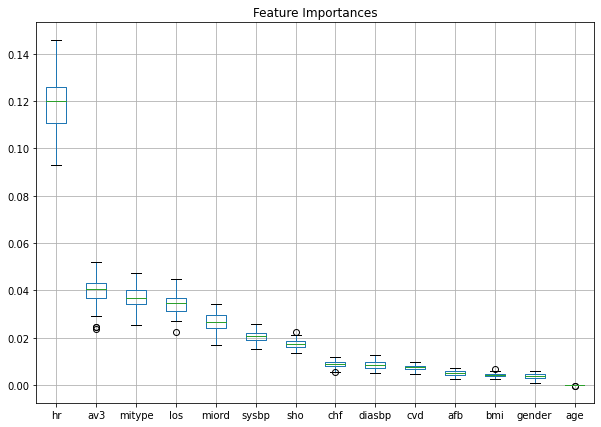

In [24]:
fig, ax = plt.subplots(figsize=(10,7))
data.boxplot(ax=ax)
ax.set_title('Feature Importances')
plt.show()

In [25]:
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.1190 ± 0.0219,hr
0.0398 ± 0.0115,av3
0.0369 ± 0.0088,mitype
0.0342 ± 0.0078,los
0.0267 ± 0.0072,miord
0.0205 ± 0.0047,sysbp
0.0175 ± 0.0035,sho
0.0088 ± 0.0026,chf
0.0084 ± 0.0033,diasbp
0.0074 ± 0.0022,cvd


In [26]:
cox = make_pipeline(preprocessor, CoxPHSurvivalAnalysis())
cox.fit(X_trn, y_trn)

ci_cox = concordance_index_censored(y_test["fstat"], y_test["lenfol"], cox.predict(X_test))
print(f'The c-index of Cox is given by {ci_cox[0]:.3f}')

The c-index of Cox is given by 0.739


In [27]:
np.random.seed(0)
seeds = np.random.permutation(1000)[:25]

param_distributions = {
    'coxphsurvivalanalysis__alpha': reciprocal(0.1, 100),
}

# alpha = model_random_search.best_params_['coxphsurvivalanalysis__alpha']
cox_scores = []
rsf_scores = []
for _seed in seeds:
    X_trn, X_test, y_trn, y_test = train_test_split(X, y, random_state=_seed)
  
    cox_best = make_pipeline(preprocessor, CoxPHSurvivalAnalysis())
    cox_best.fit(X_trn, y_trn)
    ci_cox = concordance_index_censored(y_test["fstat"], y_test["lenfol"], cox_best.predict(X_test))
    cox_scores.append(ci_cox[0])

    rsf = make_pipeline(preprocessor, RandomSurvivalForest(n_estimators=1000, 
                                                           min_samples_split=10,
                                                           min_samples_leaf=15,
                                                           max_features="sqrt",
                                                           n_jobs=-1,
                                                           random_state=42))
    rsf.fit(X_trn, y_trn)
    ci_rsf = concordance_index_censored(y_test["fstat"], y_test["lenfol"], rsf.predict(X_test))
    rsf_scores.append(ci_rsf[0])

In [28]:
print(f'Cox proportional hazards model: Mean c-index: {np.mean(cox_scores):.3f}, standard deviation: {np.std(cox_scores):.3f}')
print(f'Random Survival Forest model: Mean c-index: {np.mean(rsf_scores):.3f}, standard deviation: {np.std(rsf_scores):.3f}')


Cox proportional hazards model: Mean c-index: 0.765, standard deviation: 0.028
Random Survival Forest model: Mean c-index: 0.762, standard deviation: 0.023


In [141]:
rsf = RandomSurvivalForest(n_estimators = 1000,
                            min_samples_split = 10,
                            min_samples_leaf = 15,
                            max_features = 'sqrt',
                            n_jobs = -1,
                            random_state = 42)
rsf.fit(X_trn,y_trn)

RandomSurvivalForest(min_samples_leaf=5, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=20)

In [138]:
pd.Series(rsf_best.predict(X_test))

0        9.684591
1      100.904334
2        5.826946
3        4.448846
4       32.353021
          ...    
120     31.352599
121     21.568554
122     48.631920
123     62.871306
124     83.598534
Length: 125, dtype: float64

In [139]:
rsf_best.score(X_test, y_test)

0.8434922550794609

In [140]:
X_test

,afb,age,av3,bmi,chf,cvd,diasbp,gender,hr,los,miord,mitype,sho,sysbp
282,0,57.0,0,25.82748,0,1,70.0,0,93.0,4.0,0,0,0,130.0
396,0,84.0,0,23.24075,0,1,50.0,1,100.0,12.0,0,0,0,85.0
308,0,59.0,0,28.62989,0,0,88.0,0,72.0,4.0,0,0,0,140.0
333,0,45.0,0,37.65760,0,0,102.0,0,68.0,4.0,0,1,0,155.0
449,0,80.0,0,22.88965,0,1,84.0,0,99.0,5.0,1,0,0,179.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,0,80.0,0,19.65076,0,1,82.0,1,64.0,8.0,0,1,0,189.0
137,0,58.0,0,21.28707,0,0,67.0,0,90.0,8.0,1,1,0,116.0
226,0,58.0,0,34.43664,0,1,11.0,0,89.0,5.0,0,1,0,177.0
58,0,84.0,0,23.56005,0,1,66.0,1,135.0,2.0,1,0,0,111.0


In [146]:
X_test_sorted = X_test.sort_values(by=["age", "diasbp"])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))
X_test_sel

,afb,age,av3,bmi,chf,cvd,diasbp,gender,hr,los,miord,mitype,sho,sysbp
110,0,30.0,0,29.85998,0,0,102.0,0,90.0,2.0,0,1,0,175.0
302,0,36.0,0,31.64232,0,0,20.0,0,98.0,1.0,1,0,0,132.0
333,0,45.0,0,37.65760,0,0,102.0,0,68.0,4.0,0,1,0,155.0
36,0,92.0,0,13.04546,0,0,74.0,1,70.0,6.0,0,0,0,154.0
234,1,92.0,0,27.43890,0,0,75.0,0,72.0,1.0,0,1,0,114.0
354,0,95.0,0,27.98863,1,1,62.0,0,80.0,1.0,1,1,0,111.0


In [147]:
pd.Series(rsf_best.predict(X_test_sel))

0     10.525298
1     19.962934
2      4.448846
3    117.365440
4    115.817083
5    129.644962
dtype: float64